In [2]:
! pip install torchattacks


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Loss: 1.0019
Epoch [2/10], Loss: 0.6769
Epoch [3/10], Loss: 0.5369
Epoch [4/10], Loss: 0.4285
Epoch [5/10], Loss: 0.3757
Epoch [6/10], Loss: 0.2680
Epoch [7/10], Loss: 0.2181
Epoch [8/10], Loss: 0.1764
Epoch [9/10], Loss: 0.1581
Epoch [10/10], Loss: 0.1227


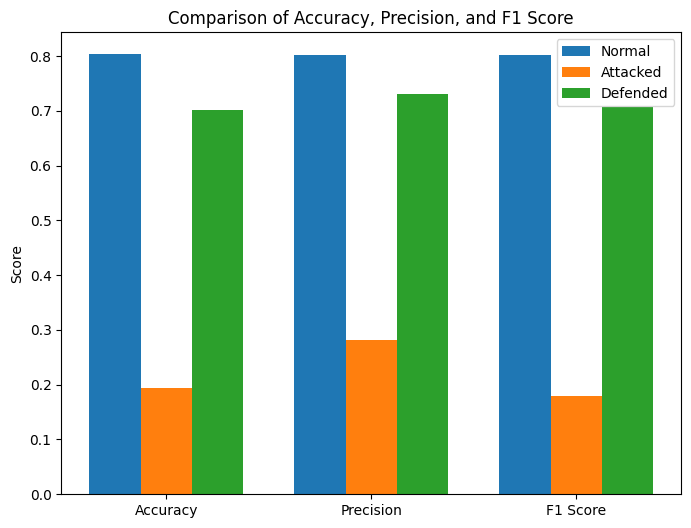

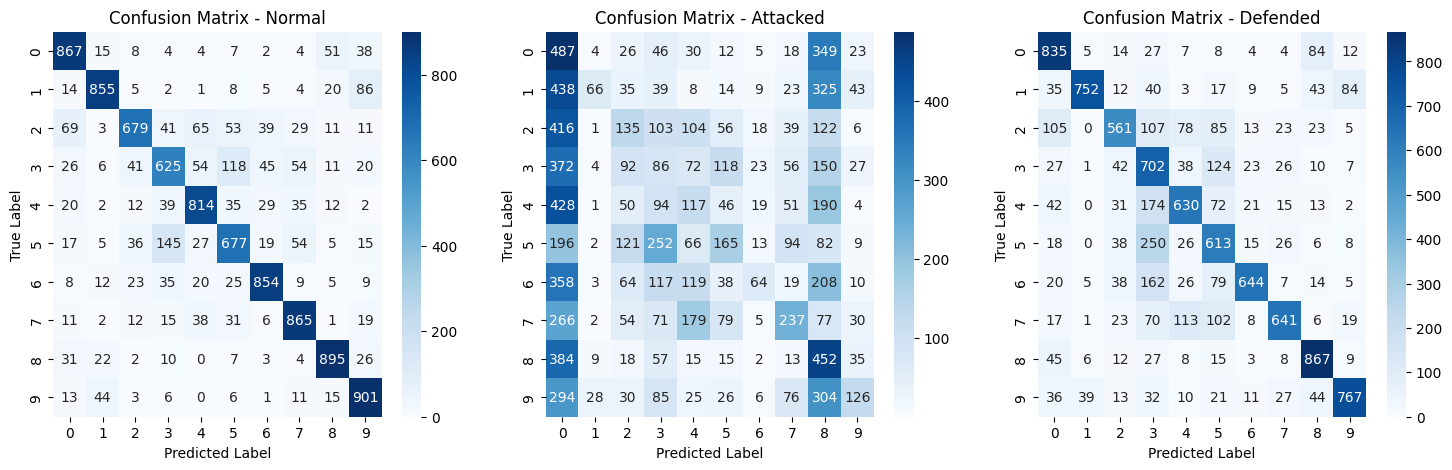

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score
from scipy.ndimage import median_filter
from torchattacks import PGD

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training set for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjusting for CIFAR-10
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Feature Squeezing Defense
def feature_squeeze(images):
    images = images.cpu().numpy()
    squeezed_images = np.array([median_filter(img, size=2) for img in images])
    return torch.tensor(squeezed_images).to(device)

# Train the model
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")
    return model

model = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10)

# Generate adversarial examples using PGD Attack
pgd_attack = PGD(model, eps=0.01, alpha=0.01, steps=7)
attacked_images, attacked_labels = [], []
model.eval()

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    adv_images = pgd_attack(images, labels)
    attacked_images.append(adv_images.cpu())
    attacked_labels.append(labels.cpu())

attacked_images = torch.cat(attacked_images)
attacked_labels = torch.cat(attacked_labels)

# Evaluate function
def evaluate_model(model, data_loader, apply_squeeze=False):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            if apply_squeeze:
                images = feature_squeeze(images)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true, y_pred)

    return acc, precision, f1, conf_matrix

# Normal Model Evaluation
normal_acc, normal_precision, normal_f1, normal_conf_matrix = evaluate_model(model, test_loader)

# Attacked Model Evaluation
attacked_loader = DataLoader(list(zip(attacked_images, attacked_labels)), batch_size=batch_size, shuffle=False)
attacked_acc, attacked_precision, attacked_f1, attacked_conf_matrix = evaluate_model(model, attacked_loader)

# Defended Model Evaluation using Feature Squeezing
defended_acc, defended_precision, defended_f1, defended_conf_matrix = evaluate_model(model, test_loader, apply_squeeze=True)

# Improved Bar Chart for Comparison
metrics = ['Accuracy', 'Precision', 'F1 Score']
data = {
    'Normal': [normal_acc, normal_precision, normal_f1],
    'Attacked': [attacked_acc, attacked_precision, attacked_f1],
    'Defended': [defended_acc, defended_precision, defended_f1]
}

fig, ax = plt.subplots(figsize=(8, 6))
x = np.arange(len(metrics))
width = 0.25

ax.bar(x - width, data['Normal'], width, label='Normal')
ax.bar(x, data['Attacked'], width, label='Attacked')
ax.bar(x + width, data['Defended'], width, label='Defended')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Comparison of Accuracy, Precision, and F1 Score')
ax.legend()

plt.show()


# Visualize Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, matrix, title in zip(axes, [normal_conf_matrix, attacked_conf_matrix, defended_conf_matrix], ['Normal', 'Attacked', 'Defended']):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.show()